In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

C:\Users\Pehansi Karunaratne\AppData\Local\Temp\ipykernel_15224\1254942327.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Loading data
df = pd.read_csv('Datasets/balanced_augmented_dataset.csv')
df.head()

,Complaints,Department
0,In the router there is a LOS bulb which is bli...,Technical
1,I made the complaint about my telephone is not...,Technical
2,"They said that to make the speed faster, we h...",Technical
3,"My fiber connection, they have laid over the e...",Technical
4,I have to have the wireless connection to the ...,Technical


In [3]:
df.shape

(1050, 2)

## Text Preprocessing

In [4]:
import re # for regular expressions
import string

In [5]:
# Convert to lowercase
df['Complaints'] = df['Complaints'].str.lower()

In [6]:
# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df['Complaints'] = df['Complaints'].apply(remove_punctuation)

In [7]:
import nltk
with open('../AggroDetect_DSGP/Stopwords/corpora/stopwords/english', 'r') as file:
    stopwords = file.read().split('\n')

In [8]:
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [9]:
df['Complaints'] = df['Complaints'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [10]:
# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df['Complaints'] = df['Complaints'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [11]:
df['Complaints'].head()

0                       router lo bulb blink red right
1                         made complaint telephon work
2             said make speed faster put fiber connect
3    fiber connect laid electr line stuck hang elec...
4    wireless connect home autom system abl work ot...
Name: Complaints, dtype: object

In [12]:
df

,Complaints,Department
0,router lo bulb blink red right,Technical
1,made complaint telephon work,Technical
2,said make speed faster put fiber connect,Technical
3,fiber connect laid electr line stuck hang elec...,Technical
4,wireless connect home autom system abl work ot...,Technical
...,...,...
1045,encount custom servic repres rude unhelp type ...,HR
1046,report issu repres promis resolut never receiv...,HR
1047,tri use live chat featur support respons time ...,HR
1048,request callback assist never receiv promis ca...,HR


In [118]:
x = df['Complaints']
y = df['Department']

In [423]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=20)


vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [424]:
svm_classifier = SVC(random_state=20)

In [425]:
# Hyperparameter grid to search
param_grid = {
    'C': [0.1],
    'kernel': ['linear'],
    }

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=20),
             param_grid={'C': [0.1], 'kernel': ['linear']})

In [426]:
# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}


In [427]:
# Training the final model with the best hyperparameters on the full training dataset
final_svm_classifier = SVC(**best_params,random_state=20)
final_svm_classifier.fit(X_train_tfidf, y_train)

SVC(C=0.1, kernel='linear', random_state=20)

In [428]:
y_pred_svm = final_svm_classifier.predict(X_test_tfidf)
# Evaluate the final model on the testing dataset
report = metrics.classification_report(y_test, y_pred_svm)
print("\nClassification Report on Testing Data:")
print(report)


Classification Report on Testing Data:
              precision    recall  f1-score   support

     Billing       0.98      0.97      0.98       104
          HR       0.95      0.97      0.96        79
   Technical       0.96      0.95      0.96        80

    accuracy                           0.97       263
   macro avg       0.96      0.97      0.96       263
weighted avg       0.97      0.97      0.97       263



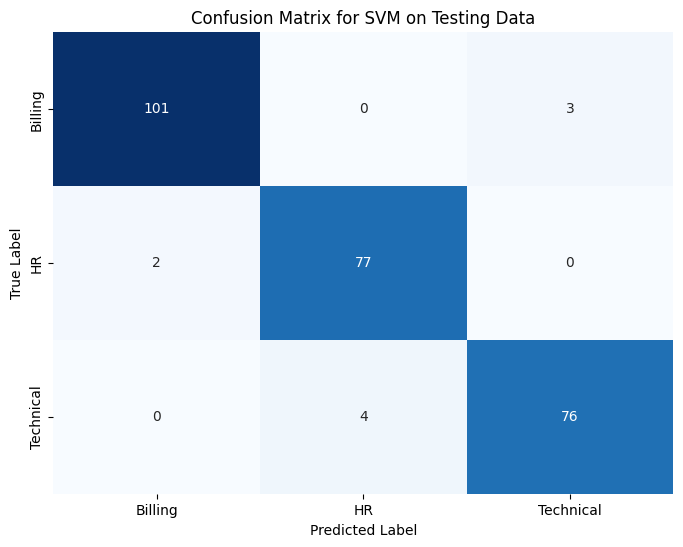

In [438]:
#Get the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=final_svm_classifier.classes_,
            yticklabels=final_svm_classifier.classes_)
plt.title('Confusion Matrix for SVM on Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [439]:
# Predict class labels on the training dataset
y_train_pred_svm = final_svm_classifier.predict(X_train_tfidf)

# Predict class labels on the testing dataset
y_test_pred_svm = final_svm_classifier.predict(X_test_tfidf)

# Calculate training accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_pred_svm)
print(f'\nTraining Accuracy: {train_accuracy:.4f}')

# Calculate testing accuracy
test_accuracy = metrics.accuracy_score(y_test, y_test_pred_svm)
print(f'Testing Accuracy: {test_accuracy:.4f}')


Training Accuracy: 0.9835
Testing Accuracy: 0.9658


In [440]:
complaint = """One of your agent was so rude to me"""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)

['HR']


In [441]:
complaint = """I was billed for a package i cancelled last year"""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)

['Billing']


In [442]:
complaint = """My data is not working and i can't send messages"""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)


['Technical']


In [443]:
complaint = """Previous agent ignored my call and didn't gave me a proper response"""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)



['HR']


In [444]:
complaint = """I need charges in my bill"""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)




['Billing']


In [445]:
complaint = """There have been consistent discrepancies in the charges reflected on my monthly statements.
Despite selecting a specific plan with clearly defined costs, I have noticed unauthorized fees and unexplained increases in my bills.
This lack of transparency has left me frustrated and confused about the actual charges for the services I am receiving."""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)


['Billing']


In [446]:
complaint = """The customer service agent I spoke to demonstrated
a complete lack of empathy towards my concerns. Instead of actively listening
and understanding the issue, the agent seemed disinterested and indifferent."""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)



['HR']


In [447]:
complaint = """Despite numerous attempts to troubleshoot the problem on my end, including resetting the router, checking for software updates,
and ensuring proper device configurations, the WiFi connection remains unstable and frequently disconnects. This has severely impacted my ability to work,
engage in online meetings, and enjoy a seamless internet experience."""

# Initialize the stemmer
stemmer = PorterStemmer()

# Remove punctuation and numbers, convert to lowercase
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.lower()  # convert to lowercase
    return text

# Remove stopwords and stem
def remove_stopwords_and_stem(text):
    stemmed_words = [stemmer.stem(word) for word in text.split() if word not in stopwords]
    return ' '.join(stemmed_words)

# Preprocess the complaint
cleaned_complaint = remove_stopwords_and_stem(preprocess_text(complaint))

# Transform the cleaned complaint using the same TF-IDF vectorizer
complaint_tfidf = vectorizer.transform([cleaned_complaint]).toarray()

# Make predictions using the best_rf_model
prediction = final_svm_classifier.predict(complaint_tfidf)

print(prediction)


['Technical']
